In [222]:
# import libraries
import os, sys
import matplotlib.pyplot as plt

# --- Configuration ---
sys.path.insert(0, '../../config')
from _utility_imports import *


In [223]:
filter_type = "true-wrong"
model_name = "lorenz96"
file_path = f"results/{filter_type}-{model_name}.h5"
datasets_tw = extract_datasets_from_h5(file_path)
t=datasets_tw['t']
ind_m = datasets_tw['obs_index']
statevec_true = datasets_tw['statevec_true']
w = datasets_tw['w']
tm_m = datasets_tw['obs_max_time'][0]

Reading data from results/true-wrong-lorenz96.h5...
Dataset 'obs_index' extracted with shape (10,)
Dataset 'obs_max_time' extracted with shape (1,)
Dataset 'statevec_true' extracted with shape (3, 1001)
Dataset 't' extracted with shape (1001,)
Dataset 'w' extracted with shape (3, 10)
Data extraction complete.


Reading data from results/EnTKF-lorenz96.h5...
Dataset 'statevec_bg' extracted with shape (3, 1001)
Dataset 'statevec_ens_full' extracted with shape (3, 30, 1001)
Dataset 'statevec_ens_mean' extracted with shape (3, 1001)
Data extraction complete.


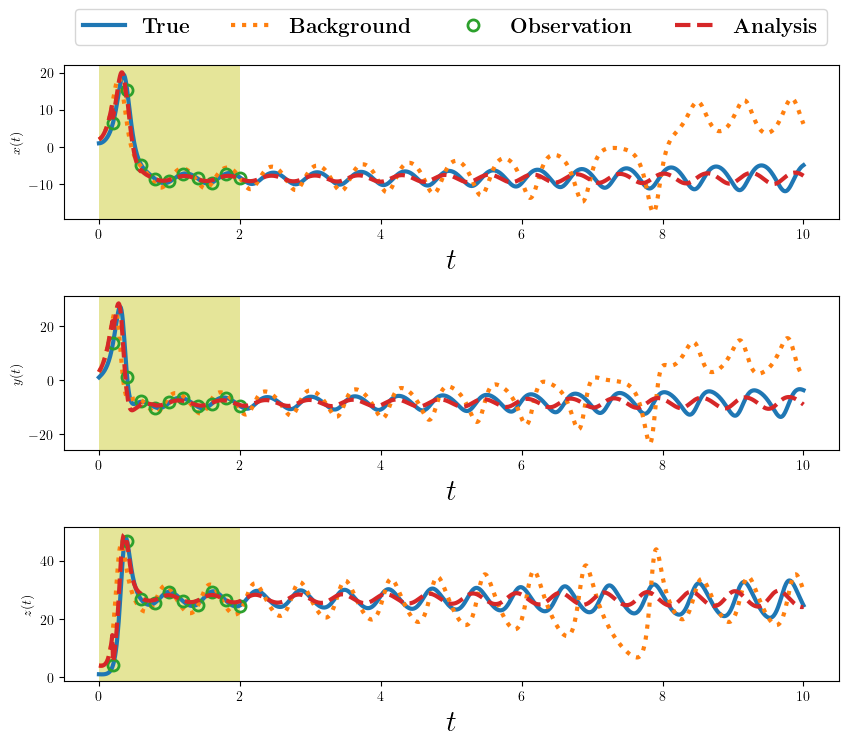

In [224]:
filter_type = "EnTKF"
file_path = f"results/{filter_type}-{model_name}.h5"
datasets = extract_datasets_from_h5(file_path)
statevec_ens_full = datasets["statevec_ens_full"]
statevec_ens_mean = datasets["statevec_ens_mean"] 
statevec_bg       = datasets["statevec_bg"]

# ---plottings ---

plt.rcParams['text.usetex'] = True

font = {'family' : 'normal',
'weight' : 'bold',
'size' : 20}

# mpl.rc('font', **font)
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(10,8)) 
ax = ax.flat
for k in range(3):
    ax[k].plot(t,statevec_true[k,:], label=r'\bf{True}', linewidth = 3) 
    ax[k].plot(t,statevec_bg[k,:], ':', label=r'\bf{Background}', linewidth = 3) 
    ax[k].plot(t[ind_m],w[k,:], 'o', fillstyle='none',  label=r'\bf{Observation}', markersize = 8, markeredgewidth = 2) 
    ax[k].plot(t,statevec_ens_mean[k,:], '--', label=r'\bf{Analysis}', linewidth = 3) 
    ax[k].set_xlabel(r'$t$',fontsize=22)
    ax[k].axvspan(0, tm_m, color='y', alpha=0.4, lw=0)
ax[0].legend(loc="center", bbox_to_anchor=(0.5,1.25),ncol =4,fontsize=15) 
ax[0].set_ylabel(r'$x(t)$')
ax[1].set_ylabel(r'$y(t)$')
ax[2].set_ylabel(r'$z(t)$')
fig.subplots_adjust(hspace=0.5)

Reading data from results/EnTKF-lorenz96.h5...
Dataset 'statevec_bg' extracted with shape (3, 1001)
Dataset 'statevec_ens_full' extracted with shape (3, 30, 1001)
Dataset 'statevec_ens_mean' extracted with shape (3, 1001)
Data extraction complete.


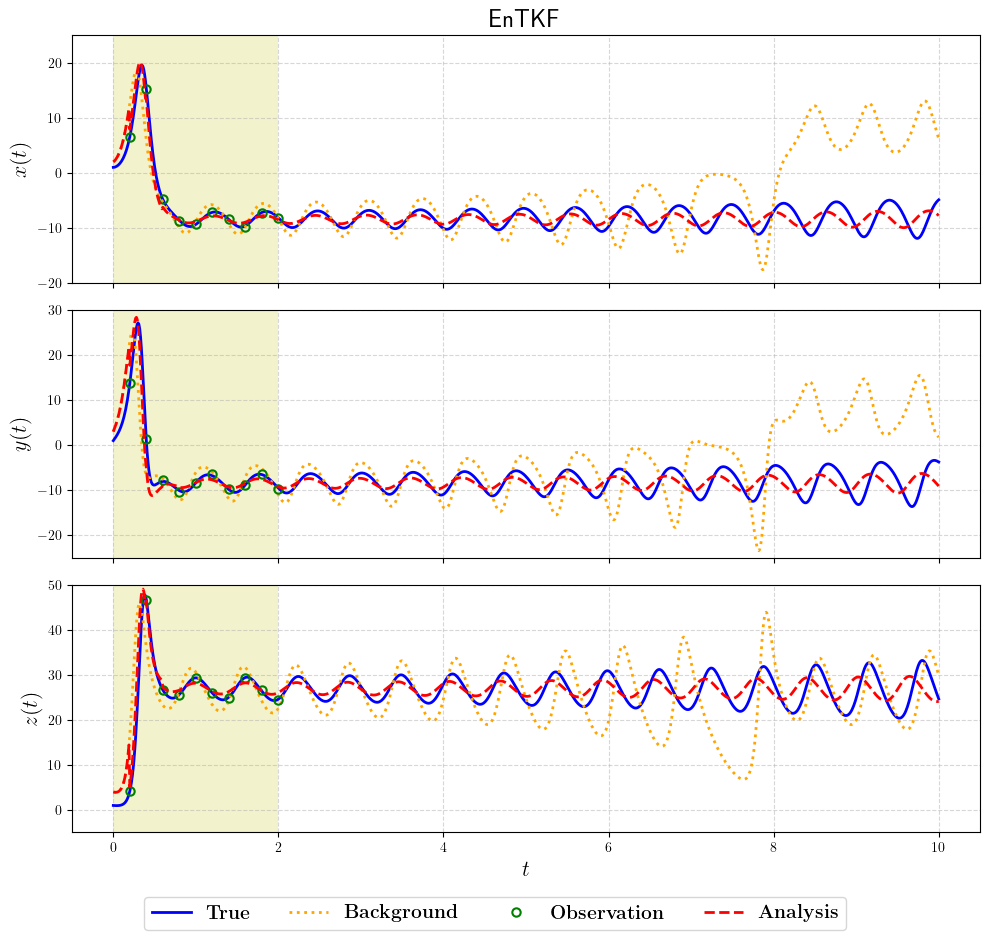

In [225]:
filter_types = ["EnKF", "DEnKF", "EnTKF", "EnRSKF"]

# Prepare data for dynamic subplot layout
available_filters = []
datasets_dict = {}

for filter_type in filter_types:
    file_path = f"results/{filter_type}-{model_name}.h5"
    try:
        datasets = extract_datasets_from_h5(file_path)
        datasets_dict[filter_type] = datasets
        available_filters.append(filter_type)  # Keep track of filters with data
    except FileNotFoundError:
        print(f"Warning: Dataset for {filter_type} not found. Skipping.")
    except KeyError as e:
        print(f"Warning: Missing dataset key {e} in {filter_type}. Skipping.")

# Dynamic layout based on available filters
ncols = len(available_filters)
if ncols == 0:
    raise ValueError("No datasets available for any filter type!")

# Dynamically adjust figsize to maintain aspect ratio
base_width = 5
base_height = 3  # Base height per subplot row
fig_width = max(base_width * ncols, 10)  # Ensure minimum width for clarity
fig_height = base_height * 3  # 3 rows for x(t), y(t), z(t)

fig, axs = plt.subplots(nrows=3, ncols=ncols, figsize=(fig_width, fig_height), sharex=True)

# If there's only one column, ensure axs is 2D
if ncols == 1:
    axs = np.expand_dims(axs, axis=1)

# Colors and line styles
styles = {
    "True": {"color": "blue", "linewidth": 2, "label": r'\bf{True}'},
    "Background": {"color": "orange", "linestyle": ":", "linewidth": 2, "label": r'\bf{Background}'},
    "Observation": {"color": "green", "marker": "o", "linestyle": "none", "fillstyle": "none", "markersize": 6, "markeredgewidth": 1.5, "label": r'\bf{Observation}'},
    "Analysis": {"color": "red", "linestyle": "--", "linewidth": 2, "label": r'\bf{Analysis}'},
}

# Define the y-axis limits for each variable
y_limits = [(-20, 25), (-25, 30), (-5, 50)]  # Adjust these to reflect realistic bounds

# Plot the available datasets
for i, filter_type in enumerate(available_filters):
    datasets = datasets_dict[filter_type]

    # Extract datasets based on filter type
    statevec_ens_full = datasets["statevec_ens_full"]
    statevec_ens_mean = datasets["statevec_ens_mean"]
    statevec_bg = datasets["statevec_bg"]

    # Plot each variable (x, y, z) in separate rows
    for k in range(3):
        ax = axs[k, i]
        ax.plot(t, statevec_true[k, :], **styles["True"])
        ax.plot(t, statevec_bg[k, :], **styles["Background"])
        ax.plot(t[ind_m], w[k, :], **styles["Observation"])
        ax.plot(t, statevec_ens_mean[k, :], **styles["Analysis"])

        if k == 2:  # Only set x-axis labels for the bottom row
            ax.set_xlabel(r'$t$', fontsize=16)
        if i == 0:  # Only set y-axis labels for the first column
            ax.set_ylabel([r'$x(t)$', r'$y(t)$', r'$z(t)$'][k], fontsize=16)

        # Set independent y-axis limits
        ax.set_ylim(y_limits[k])

        # Highlight a region of interest
        ax.axvspan(0, tm_m, color='y', alpha=0.2, lw=0)

        # Add the filter type as the title for each column
        if k == 0:
            ax.set_title(filter_type, fontsize=18, weight='bold')

        # Add gridlines
        ax.grid(True, linestyle="--", alpha=0.5)

# Add a single legend inside the plot grid
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=14)

# Adjust subplot spacing
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Automatically adjust layout to minimize whitespace
plt.tight_layout()

# Show the plot
plt.show()
 